In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

In [4]:
def create_dataset(dataset, look_back=7):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 7
future_dates = pd.date_range(start='2024-11-05', periods=3, freq='D')

In [5]:
def build_model(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)

    model.add(LSTM(hp_units, input_shape=(look_back, 1),
                   dropout=hp_dropout, recurrent_dropout=hp_dropout))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mape'])

    return model

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
# JSON 파일 경로
harris_file_path = '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/chronos/llm_sentiment_analysis_harris_time_series.json'
trump_file_path = '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/chronos/llm_sentiment_analysis_trump_time_series.json'

# JSON 파일 읽기 및 데이터프레임 변환 함수
def load_and_process_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    # JSON 데이터를 데이터프레임으로 변환
    df = pd.DataFrame(data.items(), columns=['date', 'score'])
    # 'date' 열을 datetime으로 변환
    df['date'] = pd.to_datetime(df['date'])
    # 인덱스를 'date'로 설정하고 정렬
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Harris와 Trump 데이터 처리
harris_df = load_and_process_json(harris_file_path)
trump_df = load_and_process_json(trump_file_path)

## Harris 모델링 및 예측

In [8]:
harris_values = harris_df[['score']].values
scaler_h = MinMaxScaler((0,1))
scaled_h = scaler_h.fit_transform(harris_values)

In [9]:
X_h, y_h = create_dataset(scaled_h, look_back)
train_size_h = int(len(X_h)*0.8)
X_h_train, X_h_val = X_h[:train_size_h], X_h[train_size_h:]
y_h_train, y_h_val = y_h[:train_size_h], y_h[train_size_h:]
X_h_train = X_h_train.reshape((X_h_train.shape[0], X_h_train.shape[1], 1))
X_h_val = X_h_val.reshape((X_h_val.shape[0], X_h_val.shape[1], 1))

In [10]:
tuner_harris = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='harris_tuning_single_LSTM'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
tuner_harris.search(X_h_train, y_h_train,
                    validation_data=(X_h_val, y_h_val),
                    callbacks=[early_stop],
                    verbose=1)

Trial 30 Complete [00h 00m 07s]
val_loss: 0.2117471992969513

Best val_loss So Far: 0.016559060662984848
Total elapsed time: 00h 01m 59s


In [12]:
best_hps_h = tuner_harris.get_best_hyperparameters(num_trials=1)[0]
model_harris = tuner_harris.hypermodel.build(best_hps_h)

model_checkpoint_h = ModelCheckpoint('best_model_harris.keras', monitor='val_loss', save_best_only=True)

history_h = model_harris.fit(X_h_train, y_h_train,
                             validation_data=(X_h_val, y_h_val),
                             epochs=50,
                             batch_size=16,
                             callbacks=[early_stop, model_checkpoint_h],
                             verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3406 - mape: 81.5634 - val_loss: 0.1291 - val_mape: 46.8000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1250 - mape: 37.8816 - val_loss: 0.0186 - val_mape: 18.3202
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1194 - mape: 53.3183 - val_loss: 0.0222 - val_mape: 20.4999
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0900 - mape: 39.5836 - val_loss: 0.0235 - val_mape: 18.6826
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0714 - mape: 34.8160 - val_loss: 0.0394 - val_mape: 22.7694
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0467 - mape: 29.1457 - val_loss: 0.0385 - val_mape: 22.5525
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0695 - mape: 32.0392 - val_loss: 0.0245 - val_mape: 18.8931


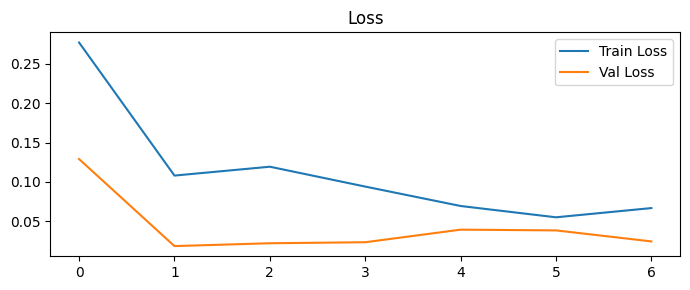

[0.27699172496795654, 0.10809709131717682, 0.11933660507202148, 0.09412559121847153, 0.06947635859251022, 0.05513487011194229, 0.0668320506811142]


In [13]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_h.history['loss'], label='Train Loss')
ax.plot(history_h.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_h.history['loss'])

In [14]:
best_model_harris = tf.keras.models.load_model('best_model_harris.keras')

In [15]:
# Harris 예측
last_sequence_h = scaled_h[-look_back:]
current_input_h = last_sequence_h.reshape((1, look_back, 1))
predictions_h = []
for i in range(3):
    pred_h = best_model_harris.predict(current_input_h, verbose=0)
    predictions_h.append(pred_h[0,0])
    current_input_h = np.append(current_input_h[:,1:,:], [[[pred_h[0,0]]]], axis=1)

In [16]:
predictions_h = scaler_h.inverse_transform(np.array(predictions_h).reshape(-1,1))
prediction_df_harris = pd.DataFrame(predictions_h, index=future_dates, columns=['predicted_score'])

## Trump 모델링 및 예측

In [17]:
trump_values = trump_df[['score']].values
scaler_t = MinMaxScaler((0,1))
scaled_t = scaler_t.fit_transform(trump_values)

In [18]:

X_t, y_t = create_dataset(scaled_t, look_back)
train_size_t = int(len(X_t)*0.8)
X_t_train, X_t_val = X_t[:train_size_t], X_t[train_size_t:]
y_t_train, y_t_val = y_t[:train_size_t], y_t[train_size_t:]
X_t_train = X_t_train.reshape((X_t_train.shape[0], X_t_train.shape[1], 1))
X_t_val = X_t_val.reshape((X_t_val.shape[0], X_t_val.shape[1], 1))

In [19]:
tuner_trump = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='trump_tuning_single_LSTM'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
tuner_trump.search(X_t_train, y_t_train,
                   validation_data=(X_t_val, y_t_val),
                   callbacks=[early_stop],
                   verbose=1)

Trial 30 Complete [00h 00m 06s]
val_loss: 0.02666597068309784

Best val_loss So Far: 0.02276611141860485
Total elapsed time: 00h 01m 59s


In [21]:
best_hps_t = tuner_trump.get_best_hyperparameters(num_trials=1)[0]
model_trump = tuner_trump.hypermodel.build(best_hps_t)

model_checkpoint_t = ModelCheckpoint('best_model_trump.keras', monitor='val_loss', save_best_only=True)

history_t = model_trump.fit(X_t_train, y_t_train,
                            validation_data=(X_t_val, y_t_val),
                            epochs=50,
                            batch_size=16,
                            callbacks=[early_stop, model_checkpoint_t],
                            verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1508 - mape: 658283.2500 - val_loss: 0.2984 - val_mape: 98.1996
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0951 - mape: 794495.5000 - val_loss: 0.1897 - val_mape: 74.6446
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0557 - mape: 1471193.6250 - val_loss: 0.1062 - val_mape: 51.8010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0263 - mape: 4090534.7500 - val_loss: 0.0492 - val_mape: 36.9106
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0221 - mape: 1930647.3750 - val_loss: 0.0285 - val_mape: 30.1022


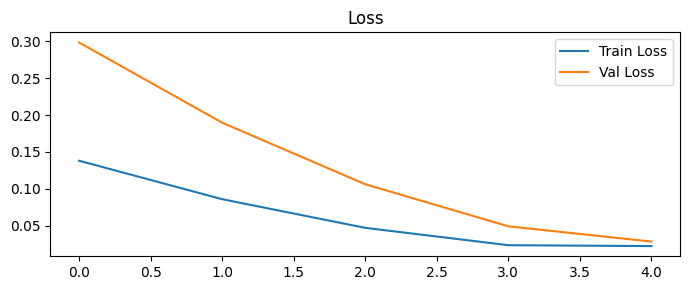

[0.1381223052740097, 0.08596722036600113, 0.047115884721279144, 0.023598119616508484, 0.022372817620635033]


In [22]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_t.history['loss'], label='Train Loss')
ax.plot(history_t.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_t.history['loss'])

In [23]:
best_model_trump = tf.keras.models.load_model('best_model_trump.keras')

In [24]:
# Trump 예측
last_sequence_t = scaled_t[-look_back:]
current_input_t = last_sequence_t.reshape((1, look_back, 1))
predictions_t = []
for i in range(3):
    pred_t = best_model_trump.predict(current_input_t, verbose=0)
    predictions_t.append(pred_t[0,0])
    current_input_t = np.append(current_input_t[:,1:,:], [[[pred_t[0,0]]]], axis=1)

In [25]:
predictions_t = scaler_t.inverse_transform(np.array(predictions_t).reshape(-1,1))
prediction_df_trump = pd.DataFrame(predictions_t, index=future_dates, columns=['predicted_score'])

## 시각화

In [26]:
print(harris_df)
print(prediction_df_harris)

               score
date                
2024-07-21  0.193176
2024-07-22  0.004363
2024-07-23  0.316000
2024-07-24  0.272350
2024-07-25  0.198071
...              ...
2024-10-31  0.351217
2024-11-01  0.400509
2024-11-02  0.300042
2024-11-03  0.381081
2024-11-04  0.401170

[107 rows x 1 columns]
            predicted_score
2024-11-05         0.340879
2024-11-06         0.351908
2024-11-07         0.358475


In [27]:
print(trump_df.index)
print(prediction_df_trump)

DatetimeIndex(['2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30',
               ...
               '2024-10-26', '2024-10-27', '2024-10-28', '2024-10-29',
               '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-02',
               '2024-11-03', '2024-11-04'],
              dtype='datetime64[ns]', name='date', length=107, freq=None)
            predicted_score
2024-11-05         0.326998
2024-11-06         0.329385
2024-11-07         0.332844


In [28]:
# 과거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기
harris_11_05 = pd.DataFrame({'score': [prediction_df_harris.loc['2024-11-05', 'predicted_score']]},
                             index=pd.to_datetime(['2024-11-05']))
trump_11_05 = pd.DataFrame({'score': [prediction_df_trump.loc['2024-11-05', 'predicted_score']]},
                            index=pd.to_datetime(['2024-11-05']))

harris_df_extended = pd.concat([harris_df, harris_11_05, prediction_df_harris], axis=0)
trump_df_extended = pd.concat([trump_df, trump_11_05, prediction_df_trump], axis=0)

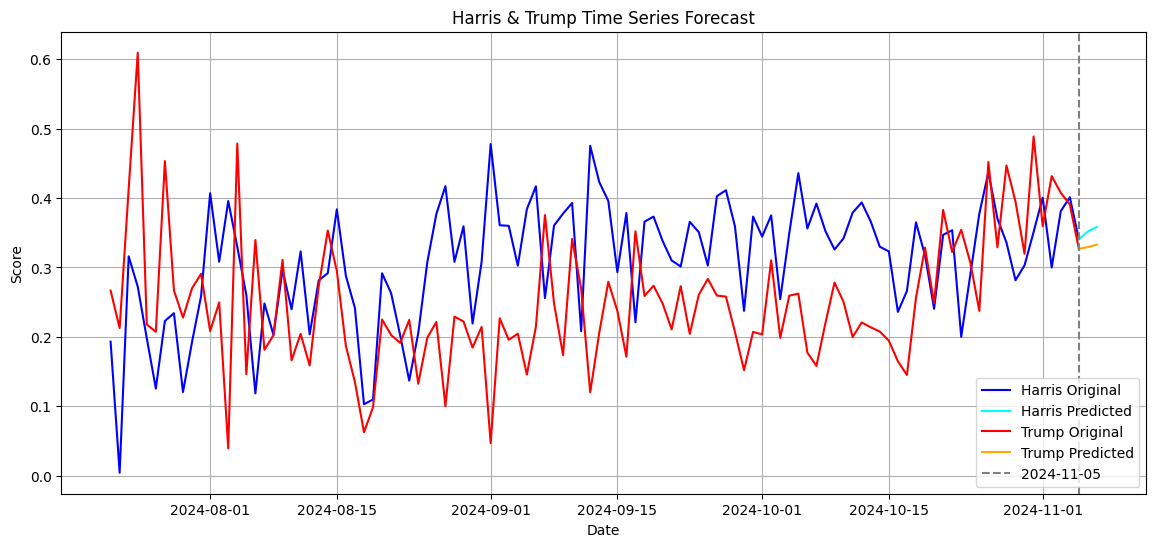

In [29]:
# Plot the extended data
plt.figure(figsize=(14, 6))

# Plot for Harris
plt.plot(harris_df_extended.index, harris_df_extended['score'], label='Harris Original', color='blue')
plt.plot(prediction_df_harris.index, prediction_df_harris['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump
plt.plot(trump_df_extended.index, trump_df_extended['score'], label='Trump Original', color='red')
plt.plot(prediction_df_trump.index, prediction_df_trump['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [30]:
# Filter the data for the specific date range (2024-11-02 to 2024-11-07)
date_range = pd.date_range(start='2024-11-02', end='2024-11-05')
pred_date_range = pd.date_range(start='2024-11-05', end='2024-11-07')

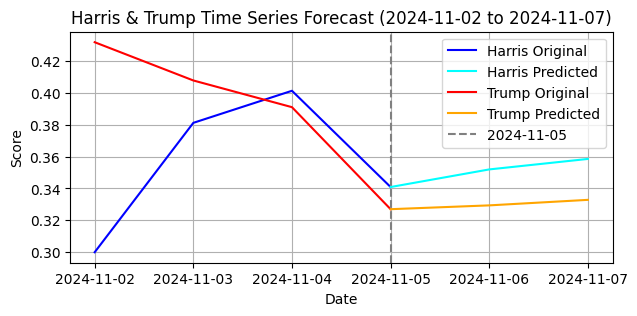

In [31]:
# Plot the extended data for the specified date range
plt.figure(figsize=(7, 3))

# Plot for Harris within the date range
harris_range = harris_df_extended.loc[date_range]
plt.plot(harris_range.index, harris_range['score'], label='Harris Original', color='blue')
harris_pred_range = prediction_df_harris.loc[pred_date_range]
plt.plot(harris_pred_range.index, harris_pred_range['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump within the date range
trump_range = trump_df_extended.loc[date_range]
plt.plot(trump_range.index, trump_range['score'], label='Trump Original', color='red')
trump_pred_range = prediction_df_trump.loc[pred_date_range]
plt.plot(trump_pred_range.index, trump_pred_range['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast (2024-11-02 to 2024-11-07)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()